# Entornos y Trayectorias

El objetivo de esta práctica es estudiar el funcionamiento de los Algoritmos de Búsqueda Aleatoria, Local, Enfriamiento Simulado y Búsqueda Tabú.

El comportamiento de los algoritmos de OCH implementados deberá compararse con un Algoritmo Greedy

Este algoritmo debe maximizar los ingresos diarios para una instalación de planta solar que tiene una capacidad total de 1000 m2 con un rendimiento del 20% de la energía recibida. La planta posee una batería que puede almacenar energía antes de venderse de 300 kWh de capacidad.

Recibirás el día anterior una previsión meteorológica con la radiación por hora en un vector R (24 enteros
con w por m2) y el precio previsto de la energía cada hora en P (24 valores reales en euros por cada kWh)

El algoritmo debe decidir que decidir por cada hora cuánta energía se venderá / comprará, la energía que se produce cada hora (o compra) y no se vende se almacena en la batería (que tiene un límite de 300kwh y comienza vacía todos los días). Toda la energía que no almacena ni vende se desperdicia.

Precio por día por kWh: a continuación, se muestran los precios reales para el día de hoy en la península, genera una lista de valores a mano deduciéndolos de la grafica en una variable o en un fichero con los valores en céntimos de euro por horas (24 valores).

Asume estos valores como precios de venta de los kWh producidos en planta.

## Librerías

In [1]:
import random
import math

# Graphs and Plots
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

### Parámetros

In [2]:
# establecer semilla
random.seed(751)

#### Precio

Precio de compra y precio de venta forman el array de 2 filas precio donde:
- precio[0] corresponde al precio_compra
- precio[1] corresponda al precio_venta

El precio se expresa en cents/kWh

In [3]:
# precio[0] = precios de compra
precio_compra = [26, 26, 25, 24,23,24,25,27,30,29,34,32,31,31,25,24,25,26,34,36,39,40,38,29]

# precio[1] = precios de venta
precio_venta = [24, 23, 22, 23,22,22,20,20,20,19,19,20,19,20,22,23,22,23,26,28,34,35,34,24] # 21 = max

precio = [precio_compra, precio_venta]

Radiacion en Wh/m2

In [4]:
# radiacion W/h en m2
radiacion = [0, 0, 0, 0, 0, 0, 0, 0, 100, 313, 500, 661, 786, 419, 865, 230, 239, 715, 634, 468, 285, 96, 0, 0]

In [5]:
horas = [0] * 24
for idx, hora in enumerate(horas):
    horas[idx] = idx

#### Constantes

In [6]:
superficie = 1000   # m2
ganancia = 0.2  # 20%
bateria_maxima = 300 # kw                           # * 1000     # kW * 1000 = W

El resultado esperado es la cantidad en euros conseguida en el día, calculada como el precio por kWh vendidos en esa Hora. Dado que lo que podamos vender dependerá de la carga de la batería en dicho momento no se puede saber de antemano el resultado, por lo que el resultado será calculado mediante una simulación usando los precios y radiación. La simulación interpretará las instrucciones en la solución actual a evaluar calculando cada hora la carga de la batería y la cantidad en euros, que puede ser negativa.

## Funciones auxiliares

#### Energia

In [7]:
def kw_to_w(energia_kw):
    '''
    kwh a wh
    '''

    return energia_kw * 1000

def w_to_kw(energia_w):
    '''
    w a kw
    '''

    return energia_w / 1000

In [8]:
def energia_a_porcentaje(energia):
    """
    :param energia: energia en kW
    :return porcentaje_bateria: equivalente de esos kW en porcentaje de la bateria
    """

    porcentaje_bateria = (energia / bateria_maxima) * 100

    return porcentaje_bateria


def porcentaje_a_energia(porcentaje):
    """
    :param porcentaje: equivalente de esos kW en porcentaje de la bateria
    :return energia: energia en kW
    """

    energia = (porcentaje * bateria_maxima) / 100

    return energia

#### Dinero

In [9]:
def cents_to_euros(cents):
    '''
    cents to euros
    '''

    return cents / 100

def euros_to_cents(euros):
    '''
    euro to cents
    '''

    return euros * 100

### Representación gráfica

In [10]:
def representar_grafica(dinero_hora, bateria_hora, hora_venta_pico, precios_venta):
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    dinero = host.twinx()
    bateria = host.twinx()

    offset = 5

    new_fixed_axis = dinero.get_grid_helper().new_fixed_axis
    dinero.axis["left"] = new_fixed_axis(loc="left", axes=dinero,
                                            offset=(0, 0))

    new_fixed_axis = bateria.get_grid_helper().new_fixed_axis
    bateria.axis["right"] = new_fixed_axis(loc="right", axes=bateria,
                                            offset=(offset, 0))



    host.set_xlabel("Horas")
    # host.set_ylabel("Dinero (€)")
    dinero.set_ylabel("Dinero (€)")
    bateria.set_ylabel("Bateria (%)")

    # Dinero acumulado en cada hora
    host.plot(horas,
             dinero_hora,
             linewidth=3,
             color='yellow',
             alpha=0.5)

    # Capacidad de la bateria en cada hora
    bat, = bateria.plot(horas,
             bateria_hora,
             color='green',
             alpha=0.8)

    # Linea de hora de venta
    # poner variable hora_venta_pico, para cuando meta el generar grafica dentro de una funcion
    dinero.plot([hora_venta_pico for _ in [0, round(max(dinero_hora))]],
             [i for i in [0, round(max(dinero_hora))]],
             linestyle=':',
             color='red')

    # coeficiente_representacion = 1
    # Precio por hora
    dinero.plot(horas,    # eje x
             precios_venta, #[p * coeficiente_representacion for p in precios_venta],
             color='blue')

    host.legend(["Dinero Acumulado", "Hora de Venta (Pico)",  "Precios de venta", "Batería"])

    bateria.axis["right"].label.set_color(bat.get_color())

    plt.show()

## Algoritmos de Búsqueda Local

### Greedy

In [11]:
def greedy(radiacion, precio):
    bateria_capacidad_porcentaje = 0
    dinero_total = 0

    hora_venta_pico = precio[1].index(max(precio[1]))

    # para la representacion de las funciones
    dinero_hora = [0 for _ in range(24)]
    bateria_hora = [0 for _ in range(24)]
    precios_venta = [0 for _ in range(24)]

    for hora in horas:
        energia_recibida = w_to_kw(radiacion[hora]) * superficie * ganancia  # a kwh
        bateria_capacidad_porcentaje += energia_a_porcentaje(energia_recibida)    # incrementar % de la bateria, obligar que sea int

        precio_venta_actual = precio[1][hora]
        precios_venta[hora] = precio_venta_actual

        if bateria_capacidad_porcentaje > 100:
            porcentaje_bateria_sobrante = bateria_capacidad_porcentaje - 100
            bateria_capacidad_porcentaje = 100
            dinero_total += cents_to_euros((porcentaje_a_energia(porcentaje_bateria_sobrante)) * precio_venta_actual)

        if hora >= hora_venta_pico:
            dinero_total += cents_to_euros((porcentaje_a_energia(bateria_capacidad_porcentaje)) * precio_venta_actual)
            bateria_capacidad_porcentaje = 0

        bateria_hora[hora] = bateria_capacidad_porcentaje
        dinero_hora[hora] = dinero_total

    representar_grafica(dinero_hora, bateria_hora, hora_venta_pico, precios_venta)

    return dinero_total

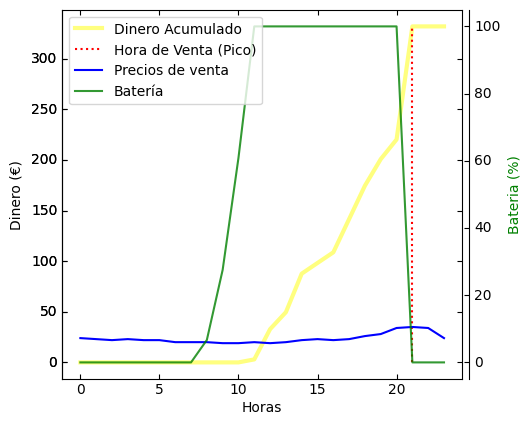

331.91

In [12]:
greedy(radiacion, precio)

### Simulated Annealing

In [ ]:
# Función para generar solución inicial
def solucion_inicial():
    # implementación de la generación de solución inicial
    solucion = [0] * 24 # Inicializar el vector con 24 ceros

    # Generar una solución válida
    for hora in range(0,24):

        numero_aleatorio = random.randint(-100,100) # Generar un num aleatorio entre el -100 y 100

        solucion[hora] = numero_aleatorio

    return solucion

# Función para generar vecino
def generador_vecino(solucion_actual):
    # implementación de la generación de vecino
    vecino = solucion_actual.copy()

    for elemento in range(len(vecino)):
        incremento = random.randint(0, 10)
        vecino[elemento] += incremento

        decremento = random.randint(0, 10)
        vecino[elemento] -= decremento

        # Se comprueba que el número resultante esté dentro del rango [-100, 100]
        vecino[elemento] = max(min(vecino[elemento], 100), -100)

    return vecino

# Función de costo a minimizar
def criterio_aceptacion(solucion, radiacion, precio, superficie, ganancia, bateria):
    # implementación de la función de costo
    return 0

def simulated_annealing():
    # Generación de la solución inicial
    solucion_actual = solucion_inicial()
    costo_actual = criterio_aceptacion(solucion_actual, radiation, precio, superficie, ganancia, bateria)

    # Inicialización de la mejor solución encontrada
    mejor_solucion = solucion_actual.copy()
    mejor_costo = costo_actual

    # Ciclo principal del algoritmo
    while T > T_final:
        for i in range(iteraciones_por_T):
            # Generación de un vecino
            vecino = generador_vecino(solucion_actual)
            costo_vecino = criterio_aceptacion(vecino, radiation, precio, superficie, ganancia, bateria)

            # Cálculo de la diferencia de costo
            delta_costo = costo_vecino - costo_actual

            # Evaluación del vecino generado
            if delta_costo < 0:
                # El vecino es mejor que la solución actual, se acepta
                solucion_actual = vecino
                costo_actual = costo_vecino

                # Actualización de la mejor solución encontrada
                if costo_actual < mejor_costo:
                    mejor_solucion = solucion_actual.copy()
                    mejor_costo = costo_actual
            else:
                # El vecino es peor que la solución actual, se acepta con cierta probabilidad
                p_aceptacion = math.exp(-delta_costo / T)
                if random.uniform(0, 1) < p_aceptacion:
                    solucion_actual = vecino
                    costo_actual = costo_vecino

        # Enfriamiento de la temperatura
        T *= factor_enfriamiento

    print("Mejor solución encontrada:", mejor_solucion)
    print("Costo de la mejor solución encontrada:", mejor_costo)

## Código general

In [ ]:
def busqueda_local(algoritmo_busqueda, funcion_evaluacion, generar_solucion_inicial, operador_de_movimiento, max_iter=1000):
    """
    Ejecuta un algoritmo de búsqueda local sobre un problema dado.

    Args:
        algoritmo_busqueda (str): el nombre del algoritmo de búsqueda a ejecutar.
        funcion_evaluacion (function): una función que recibe una solución y devuelve su evaluación.
        generar_solucion_inicial (function): una función que genera una solución aleatoria al problema.
        operador_de_movimiento (function): una función que recibe una solución y devuelve una solución vecina.
        max_iter (int): el número máximo de iteraciones a ejecutar.

    Returns:
        La mejor solución encontrada por el algoritmo de búsqueda y su evaluación.
    """
    # Generación de la solución inicial
    solucion_actual = solucion_inicial()
    evaluacion_actual = criterio_aceptacion(solucion_actual, radiation, precio, superficie, ganancia, bateria)

    # Inicialización de la mejor solución encontrada
    mejor_solucion = solucion_actual.copy()
    mejor_evaluacion = evaluacion_actual

    # Ejecutar la búsqueda local
    for i in range(max_iter):
        # Generar una solución vecina
        vecino = operador_de_movimiento(solucion_actual)

        # Evaluar la solución vecina
        evaluacion_vecino = funcion_evaluacion(vecino)

        # Determinar si la solución vecina es mejor que la actual
        if evaluacion_vecino < evaluacion_actual:
            # Actualizar la solución actual y su evaluación
            solucion_actual = vecino
            evaluacion_actual = evaluacion_vecino

            # Si la solución actual es mejor que la mejor solución, actualizarla
            if evaluacion_actual < mejor_evaluacion:
                mejor_solucion = solucion_actual
                mejor_evaluacion = evaluacion_actual

        # Si el algoritmo de búsqueda es Hill Climbing, terminar la iteración
        if algoritmo_busqueda == "Hill Climbing":
            continue

        # Si el algoritmo de búsqueda es Simulated Annealing, determinar si se acepta la solución vecina
        elif algoritmo_busqueda == "Simulated Annealing":
            temperatura = 100.0
            temperatura_minima = 1.0
            enfriamiento = 0.01

            # Calcular la probabilidad de aceptar la solución vecina
            delta_evaluacion = evaluacion_vecino - evaluacion_actual
            probabilidad_aceptacion = math.exp(-delta_evaluacion / temperatura)

            # Aceptar la solución vecina si su evaluación es mejor que la actual o si se cumple la probabilidad de aceptación
            if (evaluacion_vecino < evaluacion_actual) or (random.uniform(0, 1) < probabilidad_aceptacion):
                solucion_actual = vecino
                evaluacion_actual = evaluacion_vecino